In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import pyglstudy as gl
from pyglstudy.group_lasso import *
from pyglstudy.group_basil import group_basil
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

In [3]:
def analyze_base(out):
    diag = out['diagnostic']

    if out['error'] != '':
        logging.warning(out['error'])

    logging.debug(f"Time Init:          {diag['time_init'][0]}")
    logging.debug(f"Time Init Fit:      {diag['time_init_fit'][0]}")
    logging.debug(f"Time Screen:        {np.sum(diag['time_screen'])}")
    logging.debug(f"Time Fit:           {np.sum(diag['time_fit'])}")
    logging.debug(f"Time KKT:           {np.sum(diag['time_kkt'])}")
    logging.debug(f"Time Transform:     {diag['time_transform'][0]}")
    logging.debug(f"Time Untransform:   {diag['time_untransform'][0]}")
    
    gl_diag = diag['time_group_lasso']
    time_strong = [np.sum(d['time_strong_cd']) for d in gl_diag]
    time_active = [np.sum(d['time_active_cd']) for d in gl_diag]
    logging.debug(f"Time Strong Total:  {np.sum(time_strong)}")
    logging.debug(f"Time Active Total:  {np.sum(time_active)}")

    logging.debug(f"Number of lambdas:  {len(out['lmdas'])}")

def analyze_cov(out):
    analyze_base(out)
    
    diag = out['diagnostic']
    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd', 'time_active_grad']
    titles = ['Strong CD Time', 'Active CD Time', 'Active Gradient Update Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Iteration")
            ax.set_ylabel("Time (s)")
    plt.show()
    
def analyze_naive(out):
    analyze_base(out)
    
    diag = out['diagnostic']
    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd']
    titles = ['Strong CD Time', 'Active CD Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Loop Number")
            ax.set_ylabel("Time (s)")
    plt.show()

    _, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
    axes[0].plot(diag['n_cds'], marker='.')
    axes[0].set_title("Number of CDs")
    axes[0].set_xlabel("Basil Iteration")
    axes[0].set_ylabel("Number of CDs")
    axes[1].plot(-np.log(out['lmdas']), out['rsqs'], marker='.')
    axes[1].set_title("$R^2$")
    axes[1].set_xlabel("$-\\log(\\lambda)$")
    axes[1].set_ylabel("$R^2$")
    plt.show()

    _, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
    active_count = [out['betas'][:, j].count_nonzero() for j in range(out['betas'].shape[-1])]
    axes[0].plot(active_count, marker='.')
    axes[0].set_title("Active Count")
    axes[0].set_xlabel("$\\lambda$ index")
    axes[0].set_ylabel("Active count")

    axes[1].plot(out['diagnostic']['strong_sizes_total'], marker='.')
    axes[1].set_title("Strong Count")
    axes[1].set_xlabel("$\\lambda$ index")
    axes[1].set_ylabel("Strong count")
    plt.show()
    
    _, axes = plt.subplots(1, 1, layout='constrained', figsize=(10, 4))
    for j in tqdm(range(out['betas'].shape[0])):
        beta_j = out['betas'][j]
        if beta_j.count_nonzero() > 0:
            axes.plot(-np.log(out['lmdas']), beta_j.todense().reshape((-1,1)))
    axes.set_title('Non-zero $\\beta$ Profile')
    axes.set_xlabel('$-\log(\lambda)$')
    axes.set_ylabel('$\\beta$')
    plt.show()


In [40]:
n = 100
p = 10000
n_groups = int(p/100)
seed = 0

np.random.seed(seed)
X, beta, y, groups, group_sizes = generate_group_lasso_data(
    n, p, n_groups, rho=0.02, svd_transform=False, group_split_type="random",
).values()

In [41]:
alpha = 1
penalty = np.sqrt(group_sizes)

In [42]:
# naive
out_naive = group_basil(
    X, y, groups, group_sizes, 
    alpha=alpha,
    penalty=penalty,
    method='naive', 
    max_n_cds=int(1e5), 
    n_lambdas_iter=5,
    #use_strong_rule=False,
    use_strong_rule=True,
    max_strong_size=p,
    verbose_diagnostic=False,
    do_early_exit=False,
)
diag_naive = out_naive['diagnostic']

DEBUG:root:Time Init:          0.000168708
DEBUG:root:Time Init Fit:      0.00019020900000000002
DEBUG:root:Time Screen:        0.0026121240000000004
DEBUG:root:Time Fit:           5.2792000000000005e-05
DEBUG:root:Time KKT:           0.007475626000000001
DEBUG:root:Time Transform:     0.015947334
DEBUG:root:Time Untransform:   4.2791000000000004e-05
DEBUG:root:Time Strong Total:  2.2490000000000004e-06
DEBUG:root:Time Active Total:  0.0
DEBUG:root:Number of lambdas:  100
100%|██████████| 34/34 [00:00<00:00, 4031.39it/s]


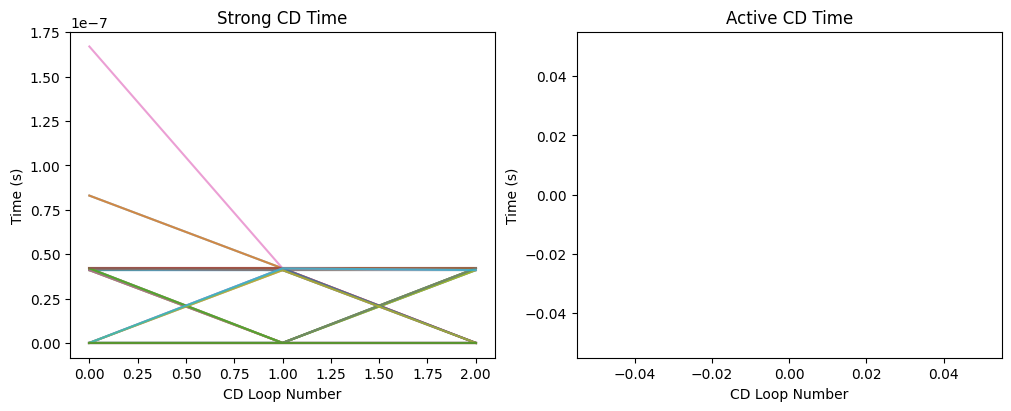

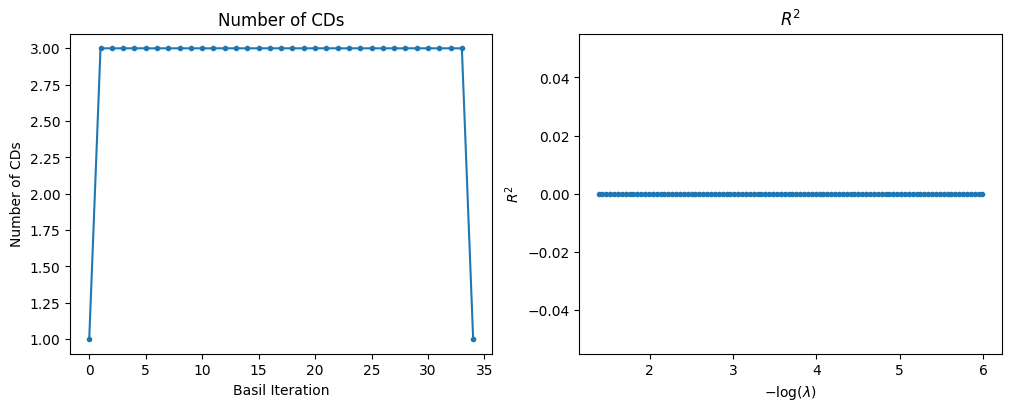

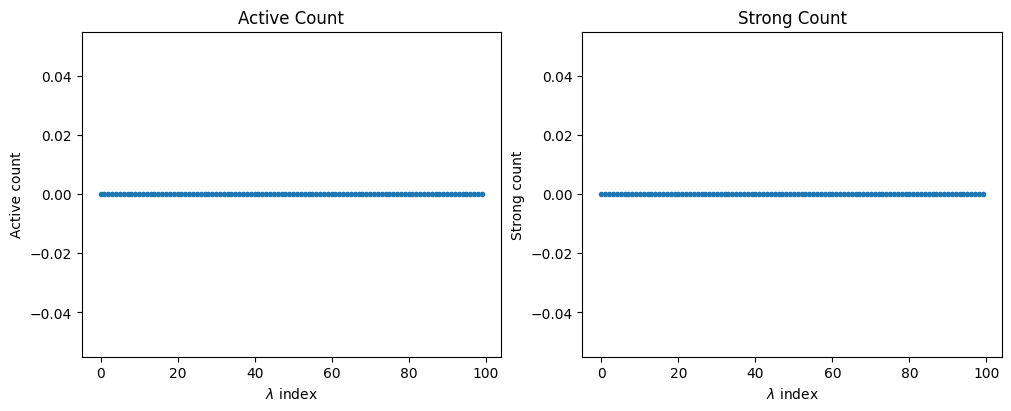

100%|██████████| 10000/10000 [00:00<00:00, 32154.23it/s]


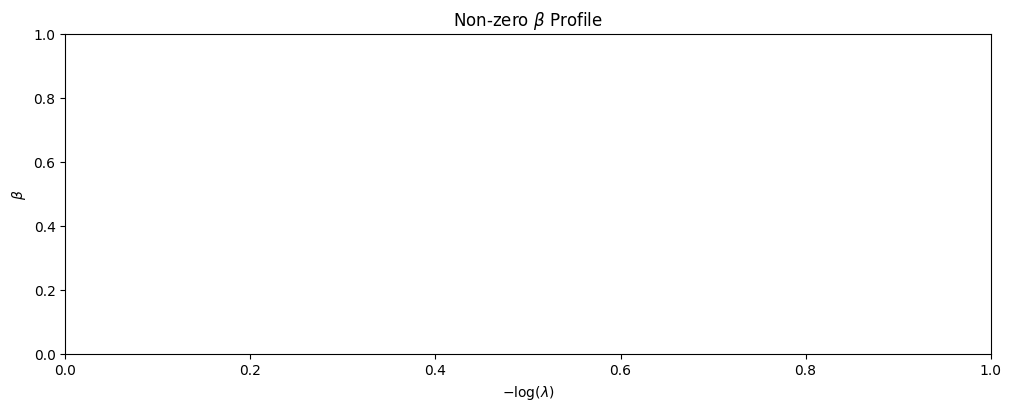

In [43]:
analyze_naive(out_naive)

In [28]:
def compute_abs_grad(
    X, y, groups, group_sizes, beta, lmda, alpha, penalty
):
    beta = np.ravel(beta.todense())
    grad = X.T @ (y - X @ beta) - lmda * (1 - alpha) * np.repeat(penalty, group_sizes) * beta
    abs_grad = np.array([
        np.linalg.norm(grad[g:g+gs])
        for g, gs in zip(groups, group_sizes)
    ])
    return abs_grad

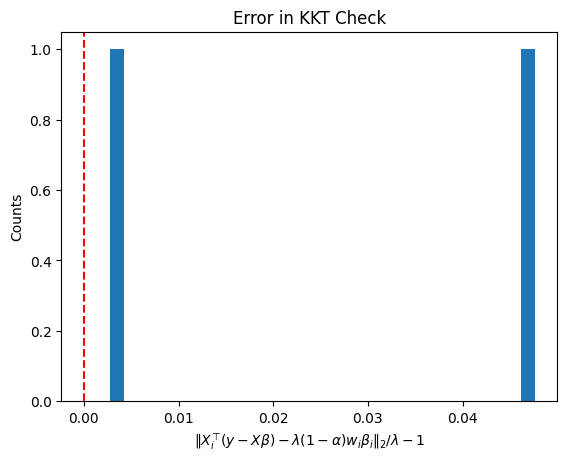

In [45]:
i = 1
beta = out_naive['betas'][:, i]
lmda = out_naive['lmdas'][i]
abs_grad = compute_abs_grad(X,y,groups,group_sizes,beta,lmda,alpha,penalty)
abs_grad_scaled = abs_grad / (lmda * alpha * penalty)
abs_grad_scaled = abs_grad_scaled[abs_grad_scaled > 1]
plt.hist(abs_grad_scaled-1, bins=30)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("$\|X_i^\\top (y-X\\beta) - \lambda (1-\\alpha) w_i \\beta_i\|_2 / \lambda - 1$")
plt.ylabel("Counts")
plt.title("Error in KKT Check")
plt.show()

In [50]:
def group_edpp(
    X, y, groups, group_sizes, betas, lmdas, alpha, penalty
):
    assert betas.shape[-1] == lmdas.shape[-1]
    assert alpha == 1

    n_checks = lmdas.shape[-1]-1
    
    grad = X.T @ y
    abs_grad = np.array([
        np.linalg.norm(grad[g : g + gs]) / pg
        for g, gs, pg in zip(groups, group_sizes, penalty)
    ])
    i_star = np.argmax(abs_grad)
    X_star = X[:, groups[i_star] : groups[i_star] + group_sizes[i_star]]

    X_norms = np.array([
        np.linalg.norm(X[:, g : g + gs])
        for g, gs in zip(groups, group_sizes)
    ])
    
    n_rejects = np.zeros(n_checks)

    for k in range(n_checks):
        b_k = np.ravel(betas[:, k].todense())
        lmda_k = lmdas[k]
        lmda_k1 = lmdas[k+1]

        theta_k = (y - X @ b_k) / lmda_k
        v1_k = y / lmda_k - theta_k if k > 0 else X_star @ (X_star.T @ y)
        v2_k = y / lmda_k1 - theta_k
        v1_k_norm = np.linalg.norm(v1_k)
        v2_k_perp = v2_k - (v1_k @ v2_k) / (v1_k_norm ** 2) * v1_k
        grad = X.T @ (theta_k + 0.5 * v2_k_perp)
        abs_grad = np.array([
            np.linalg.norm(grad[g:g+gs])
            for g, gs in zip(groups, group_sizes)
        ])
        
        thresh = penalty - 0.5 * np.linalg.norm(v2_k_perp) * X_norms
        
        n_rejects[k] = np.sum(abs_grad <= thresh)
        
    return n_rejects
    
def group_ssr(
    X, y, groups, group_sizes, betas, lmdas, alpha, penalty
):
    assert betas.shape[-1] == lmdas.shape[-1]
    assert alpha == 1

    n_checks = lmdas.shape[-1]-1
    
    n_rejects = np.zeros(n_checks)

    for k in range(n_checks):
        b_k = np.ravel(betas[:, k].todense())
        lmda_k = lmdas[k]
        lmda_k1 = lmdas[k+1]
        
        grad = X.T @ (y - X @ b_k) - lmda_k * (1 - alpha) * np.repeat(penalty, group_sizes) * b_k
        abs_grad = np.array([
            np.linalg.norm(grad[g:g+gs])
            for g, gs in zip(groups, group_sizes)
        ])
        n_rejects[k] = np.sum(abs_grad / (alpha * penalty) <= (2 * lmda_k1 - lmda_k))
        
    return n_rejects

In [51]:
out_edpp = group_edpp(
    X, y, groups, group_sizes, 
    out_naive['betas'],
    np.array(out_naive['lmdas']),
    alpha,
    penalty,
)

out_ssr = group_ssr(
    X, y, groups, group_sizes, 
    out_naive['betas'],
    np.array(out_naive['lmdas']),
    alpha,
    penalty,
)

print(out_edpp)
print(out_ssr)

/var/folders/8w/87ph5tkx60vc7f4l87071knc0000gn/T/ipykernel_12306/1896548453.py:33: RuntimeWarning: invalid value encountered in scalar divide
  v2_k_perp = v2_k - (v1_k @ v2_k) / (v1_k_norm ** 2) * v1_k


[41.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[98. 94. 73. 48. 22. 10.  6.  4.  3.  2.  1.  1.  1.  1.  1.  1.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


1000


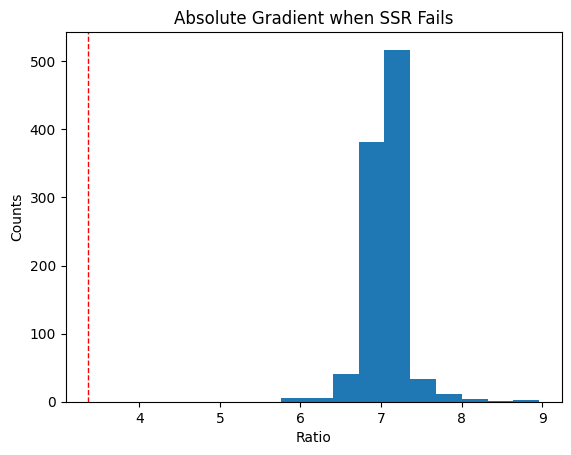

1000


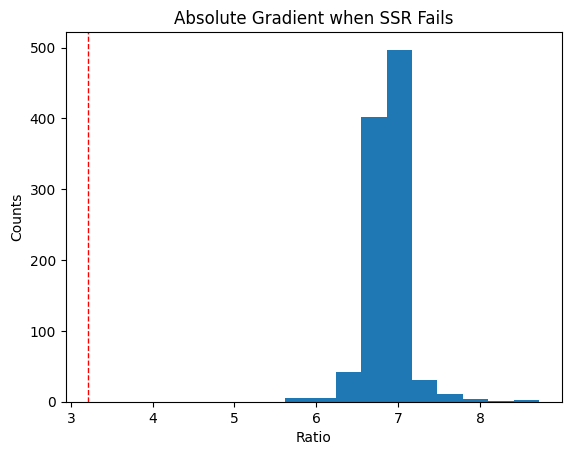

1000


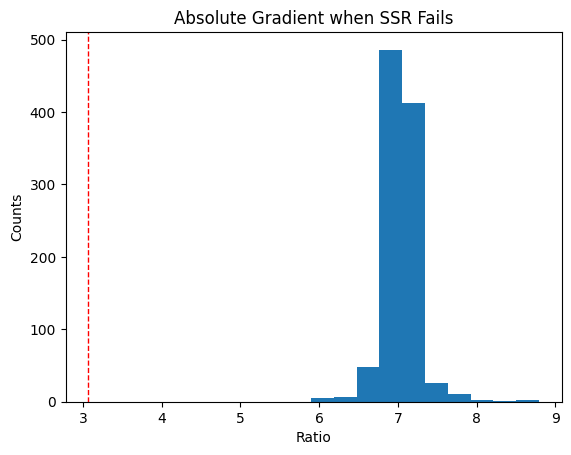

1000


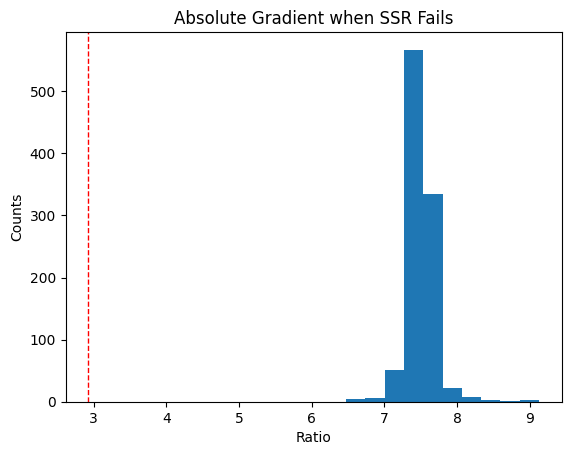

1000


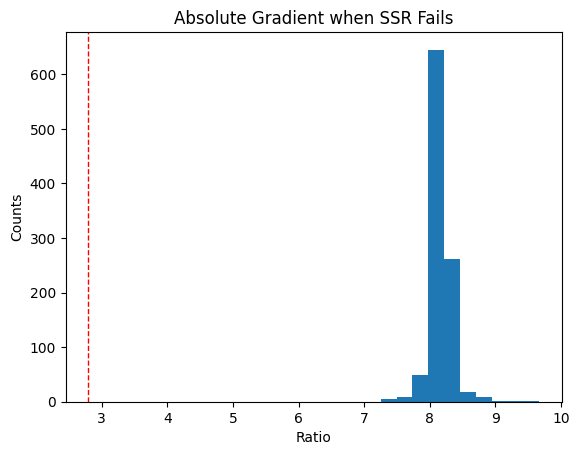

1000


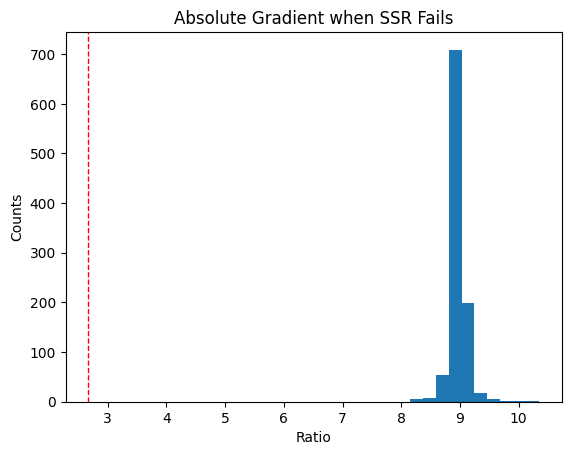

1000


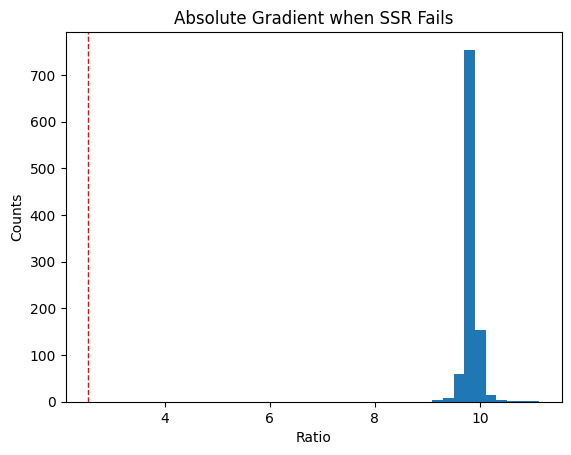

1000


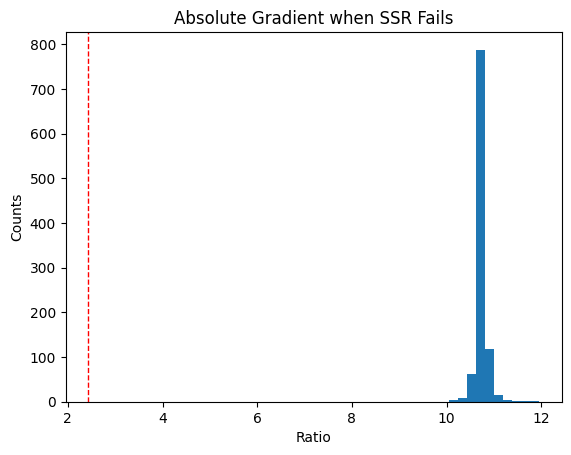

1000


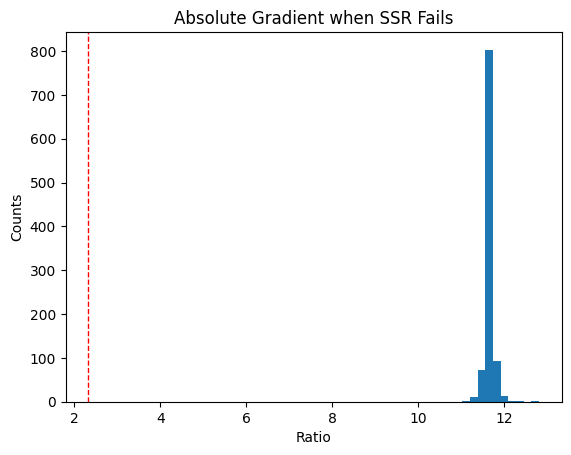

1000


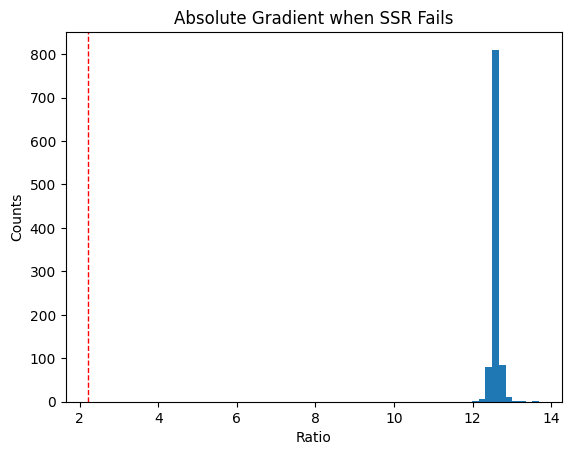

1000


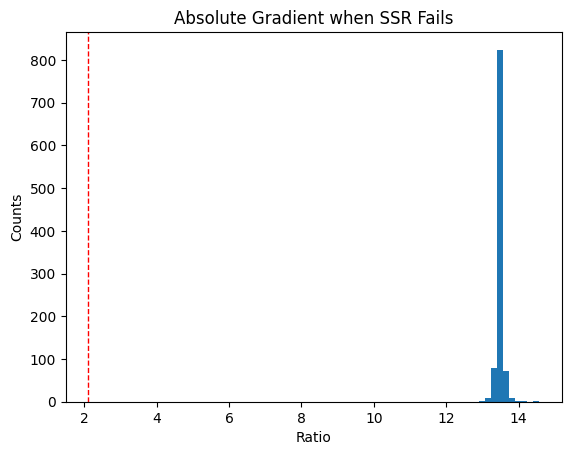

1000


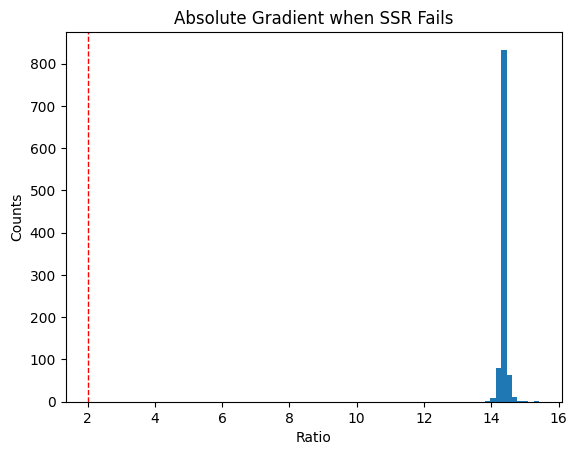

1000


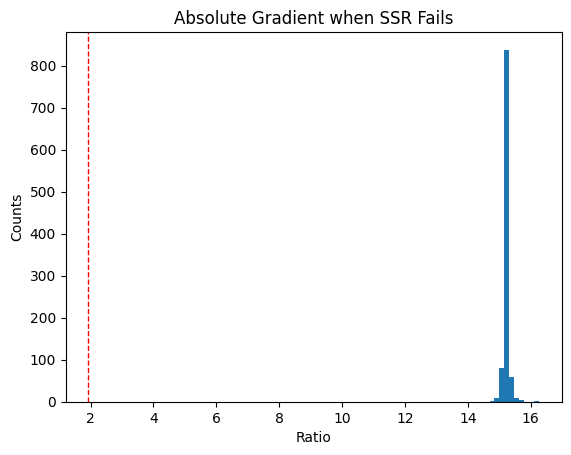

1000


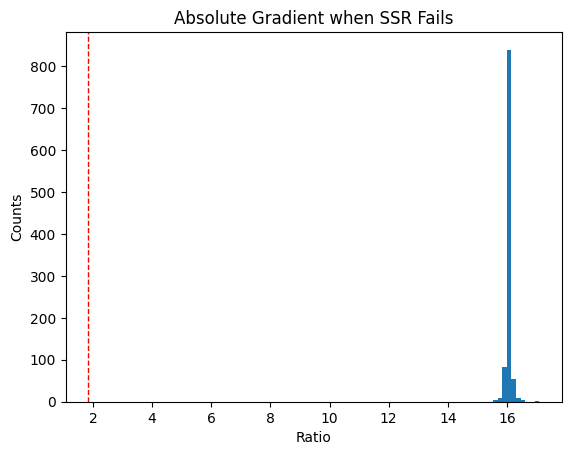

1000


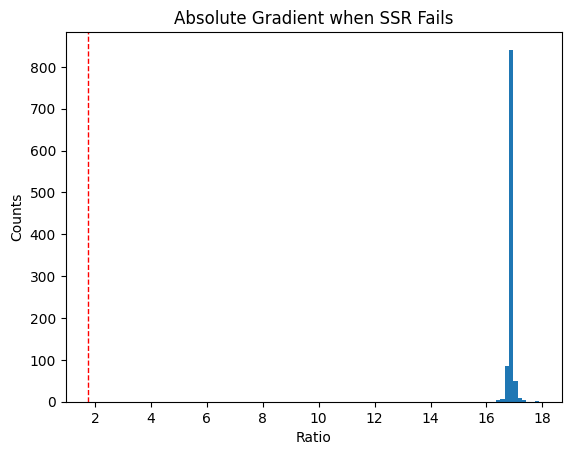

1000


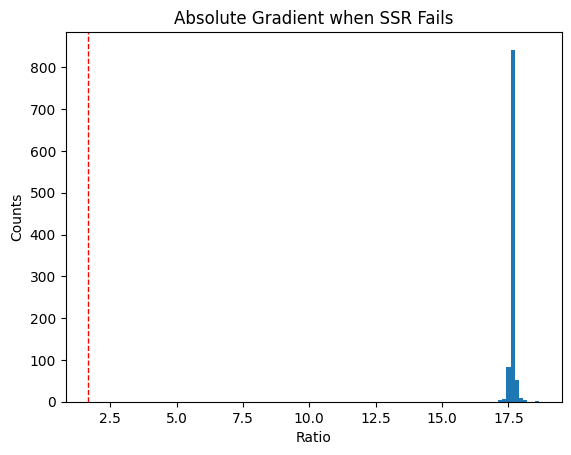

1000


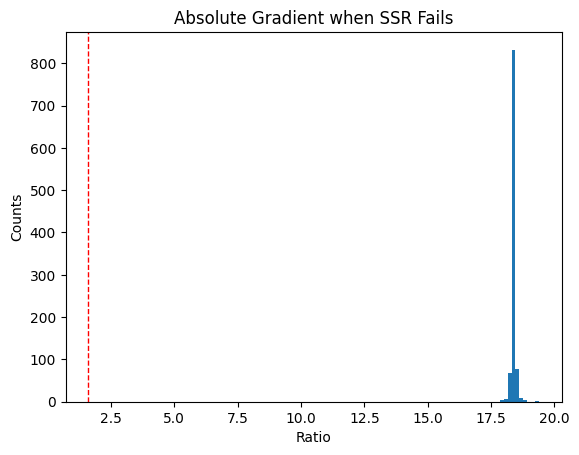

1000


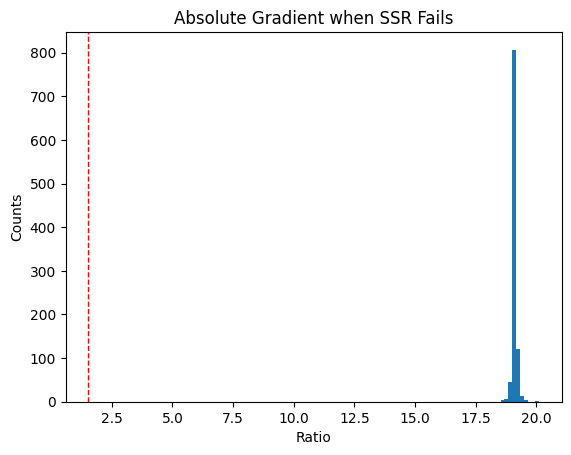

1000


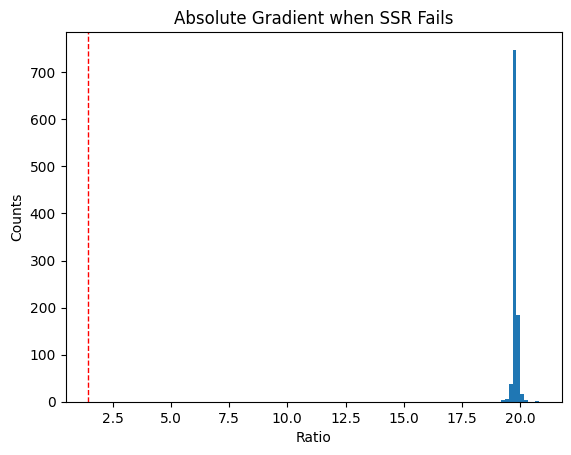

1000


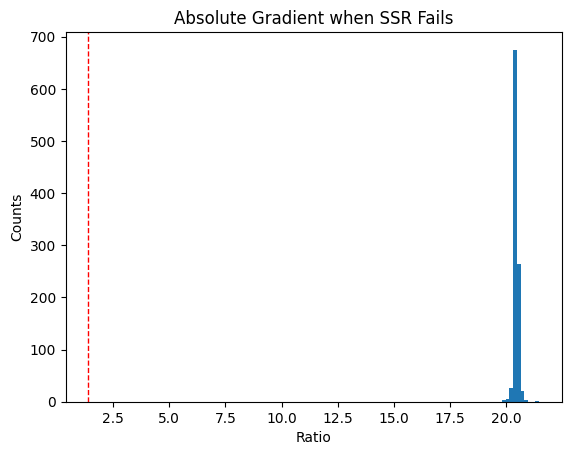

1000


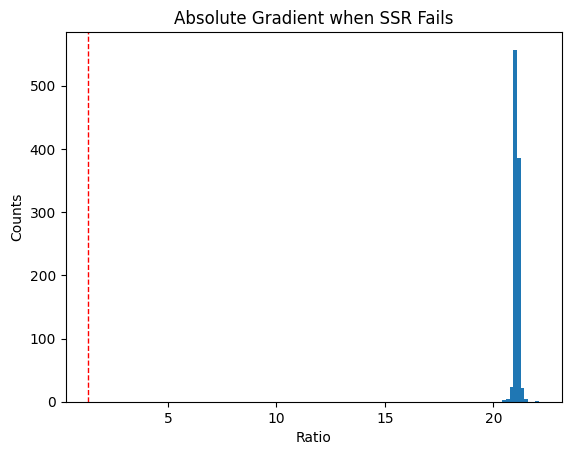

1000


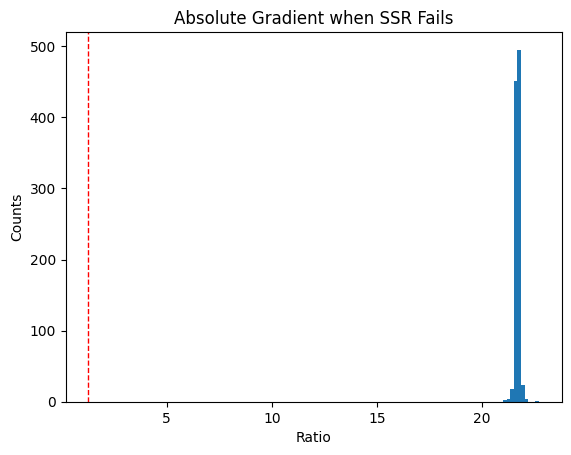

1000


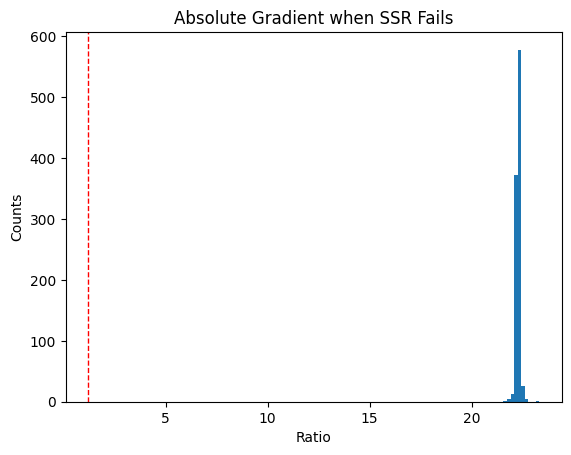

1000


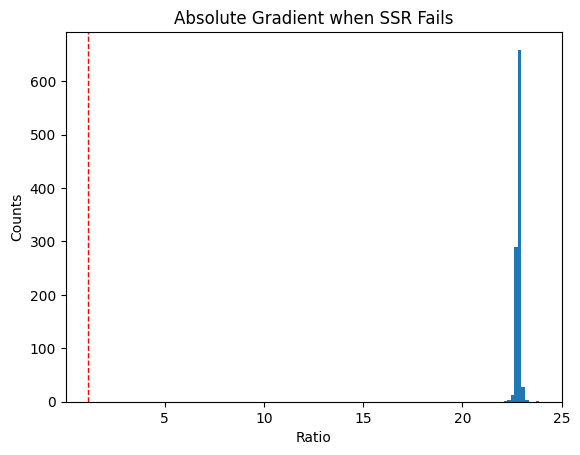

1000


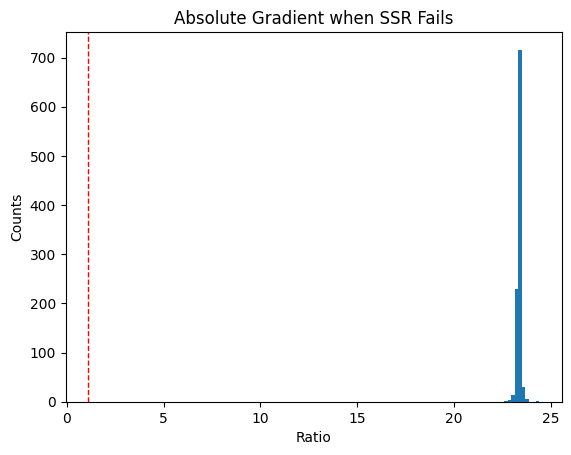

1000


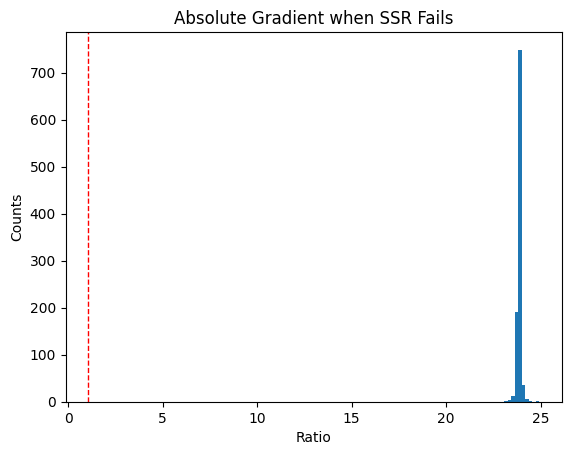

1000


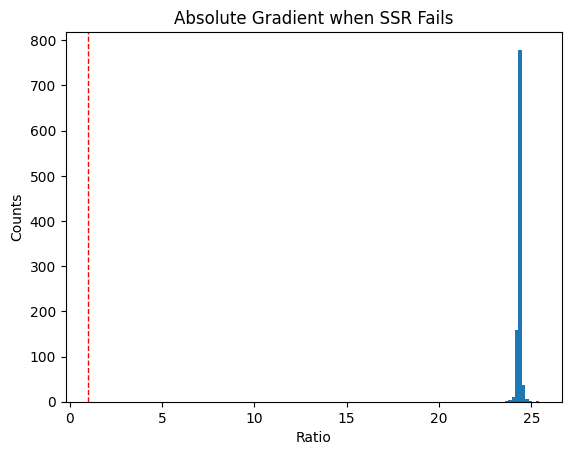

1000


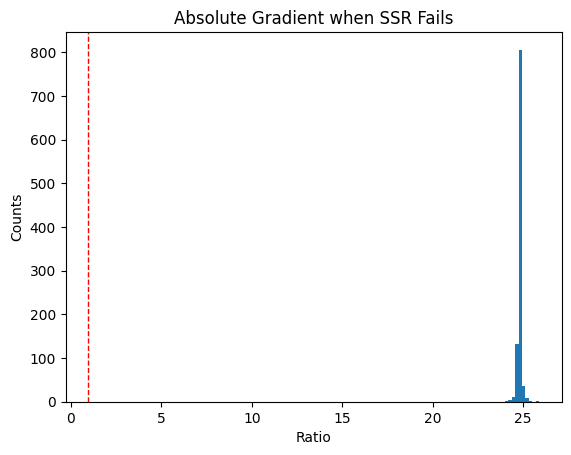

1000


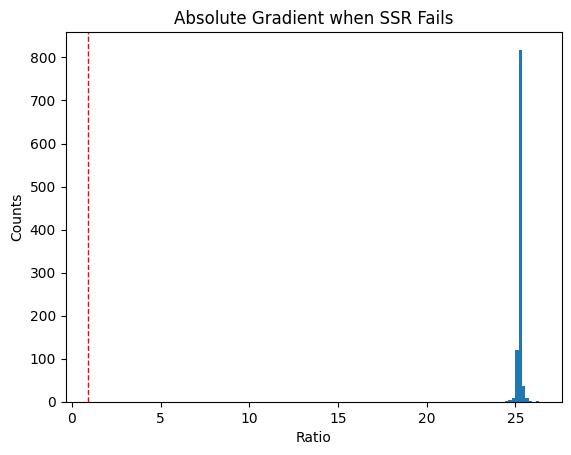

1000


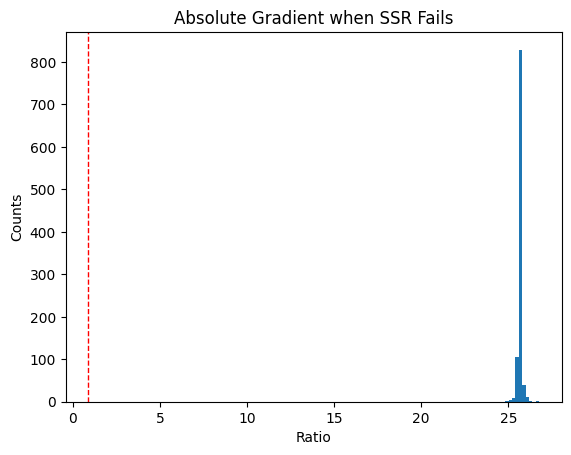

1000


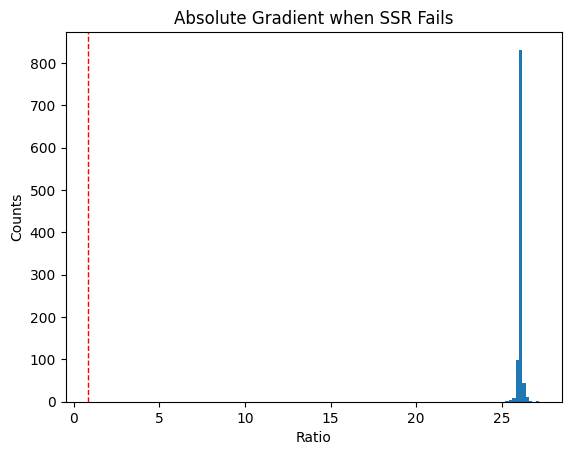

1000


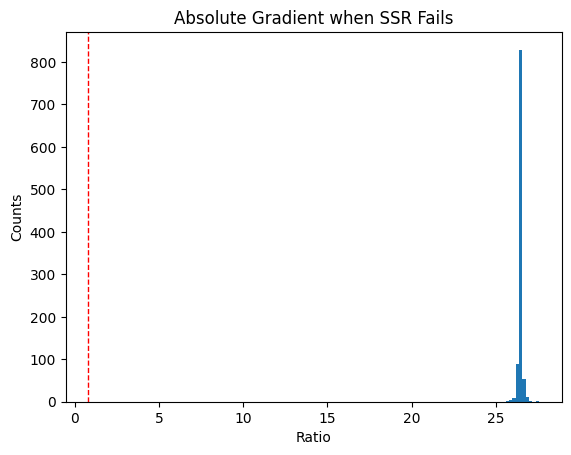

1000


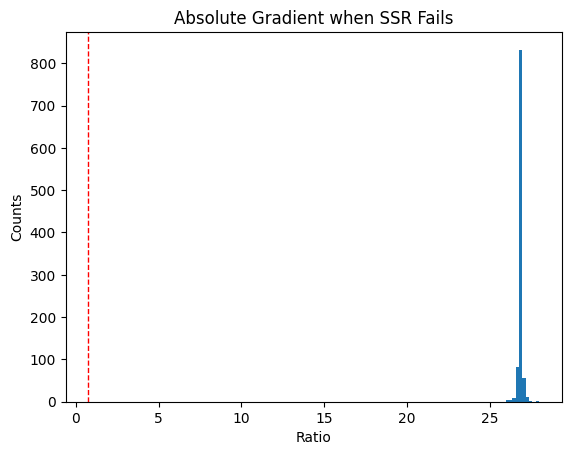

1000


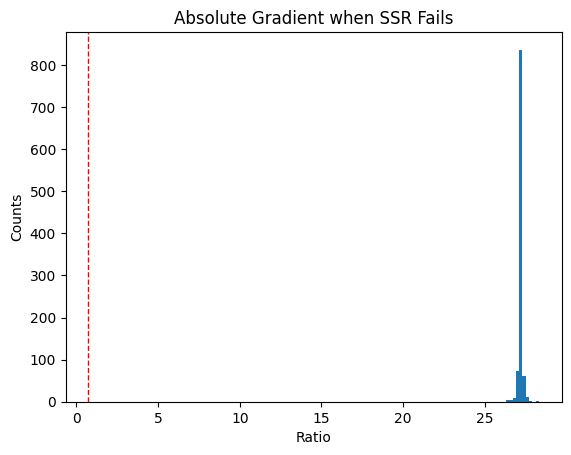

1000


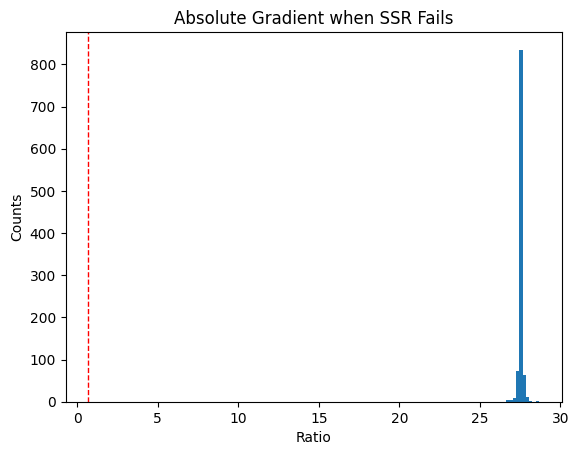

1000


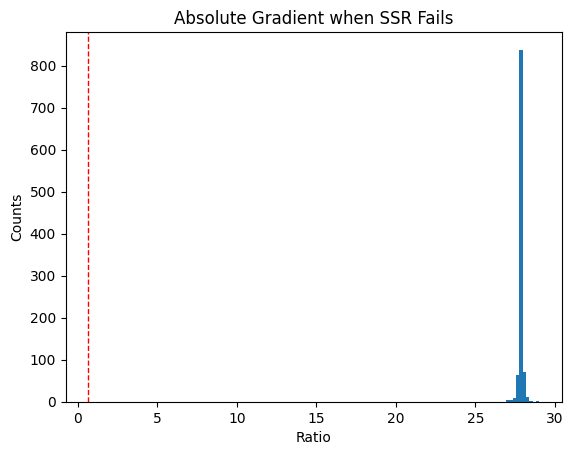

1000


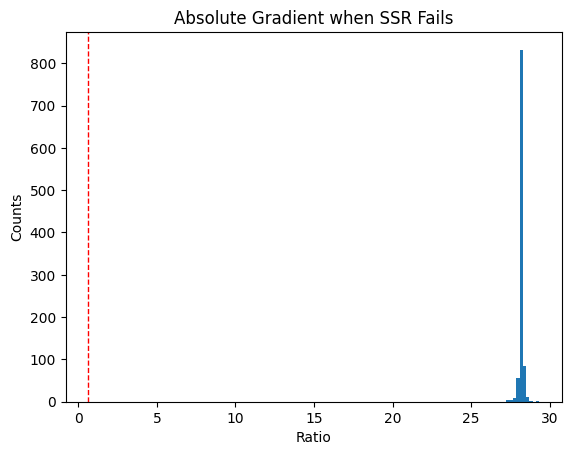

1000


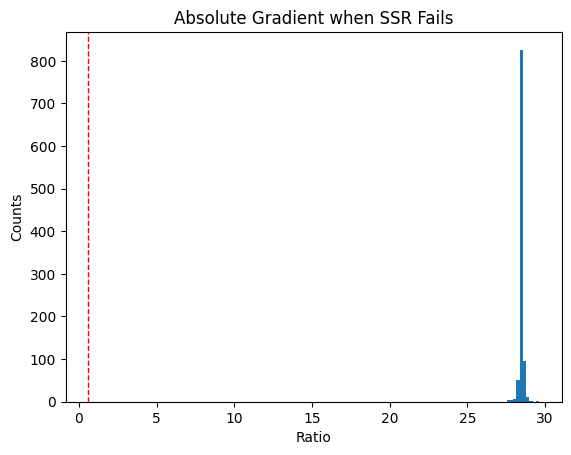

1000


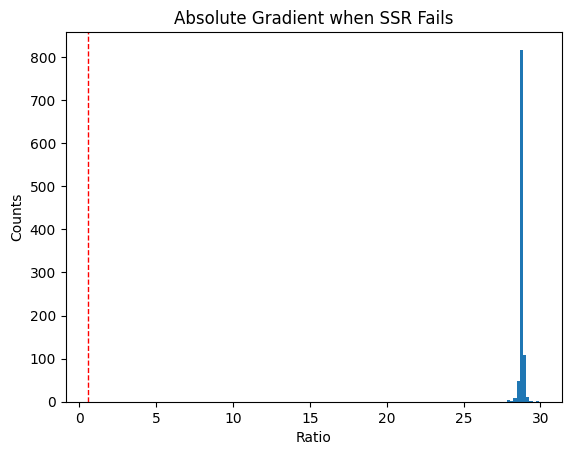

1000


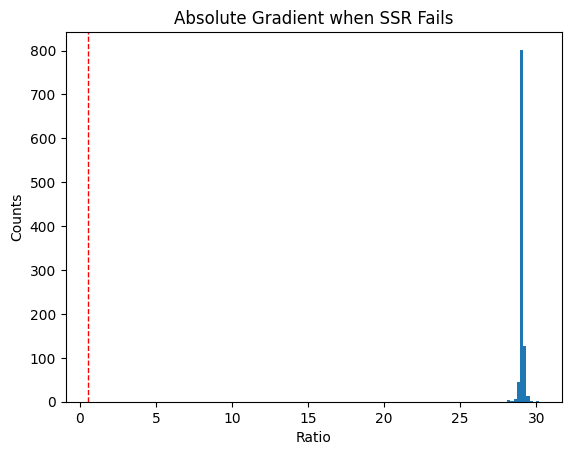

1000


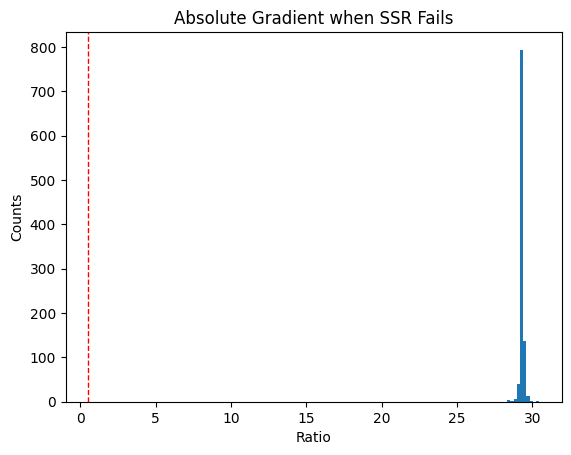

1000


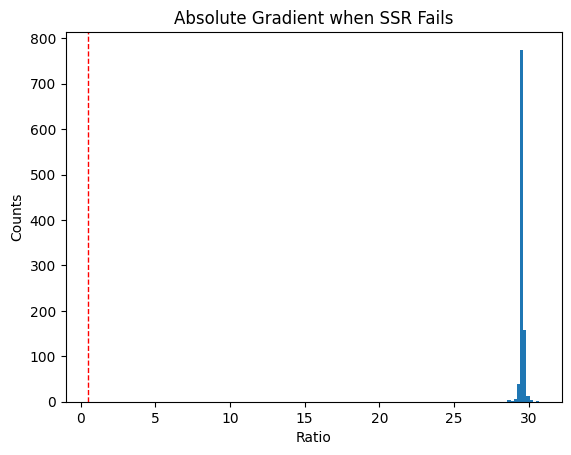

1000


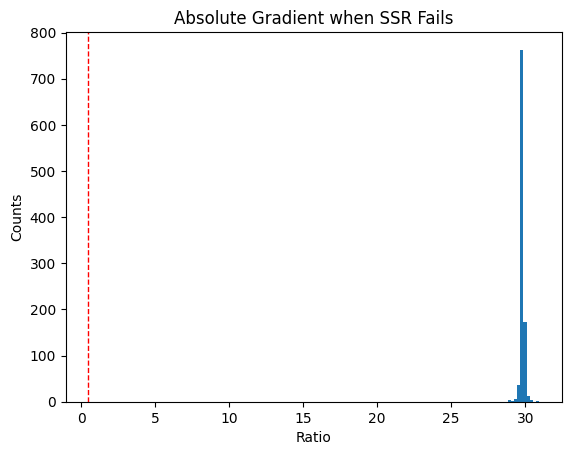

1000


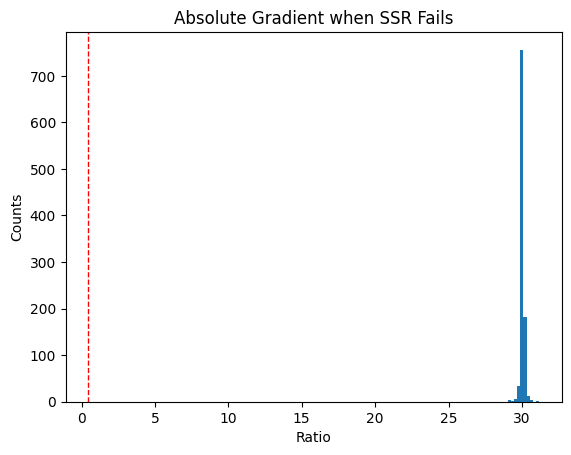

1000


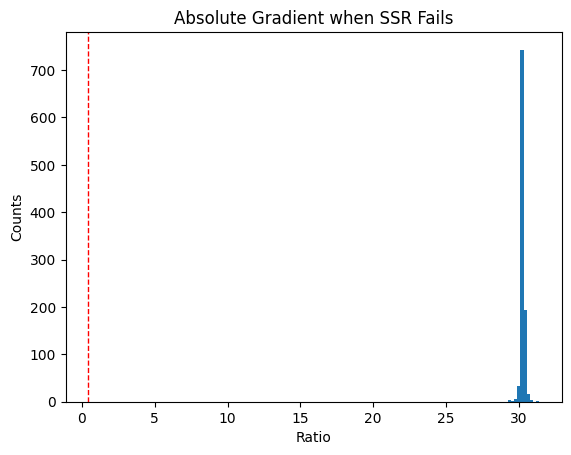

1000


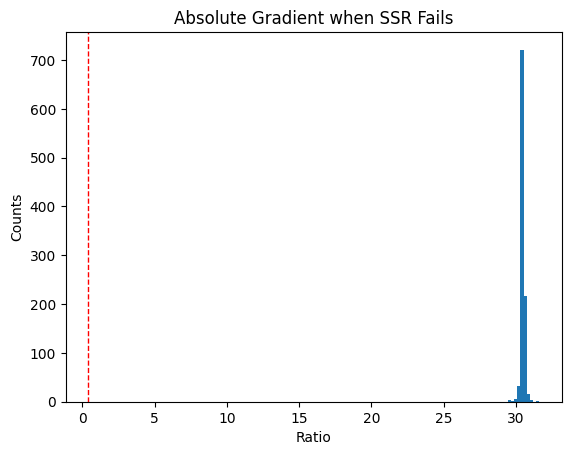

1000


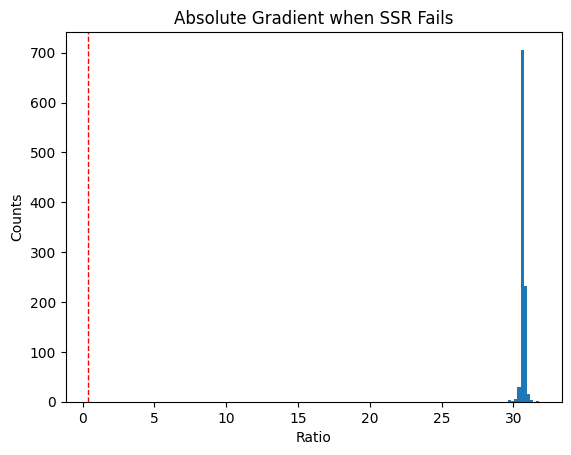

1000


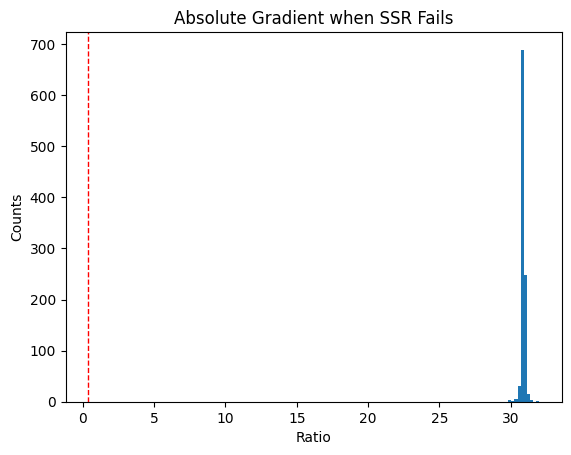

1000


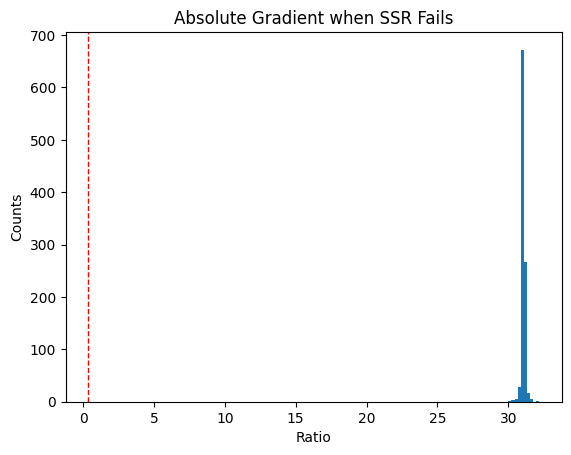

1000


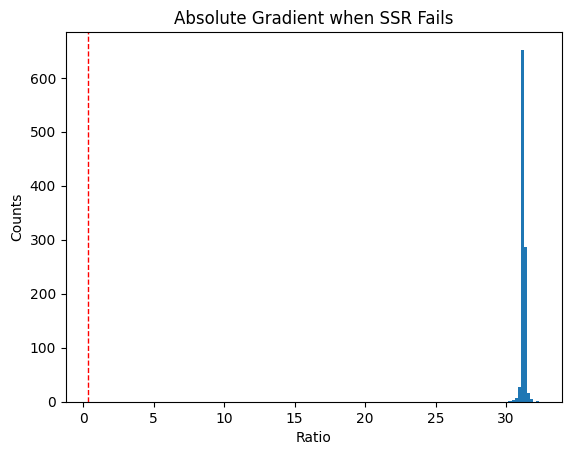

1000


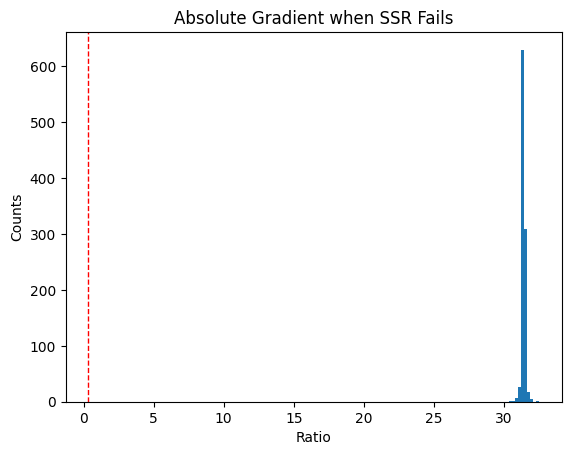

1000


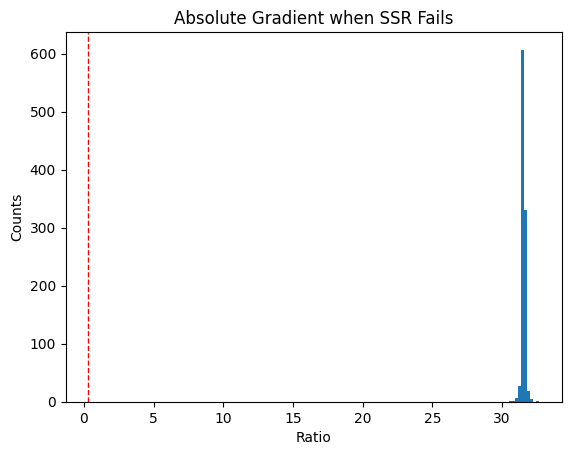

1000


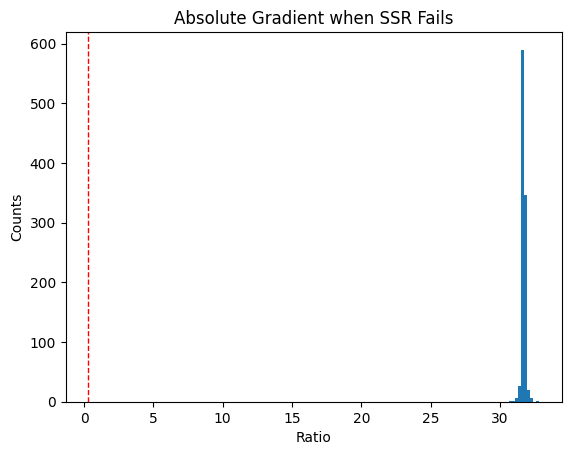

1000


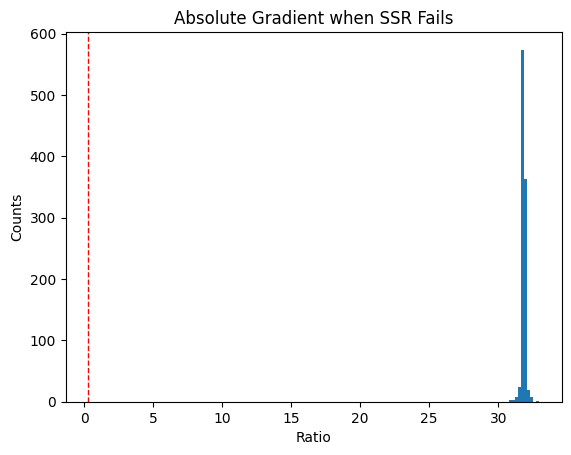

1000


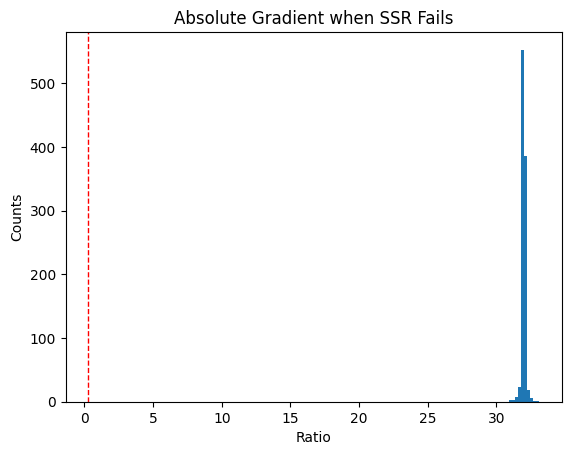

1000


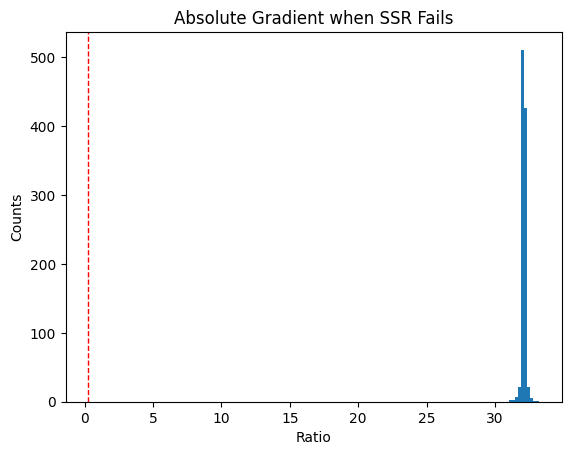

1000


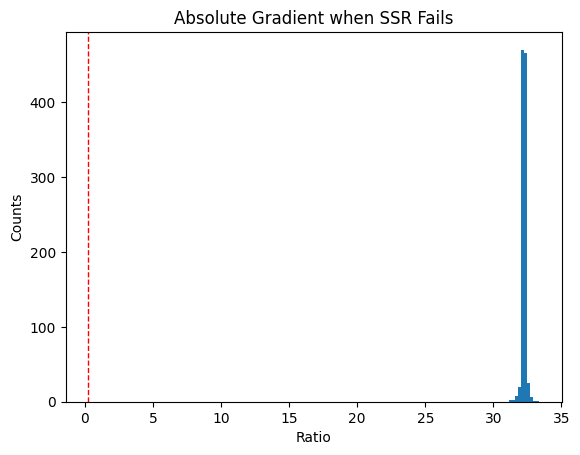

1000


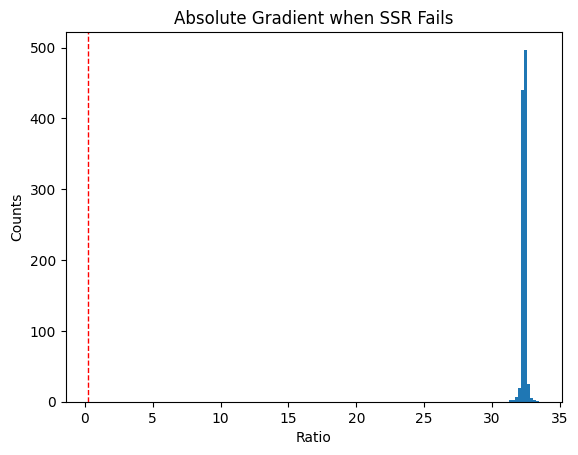

1000


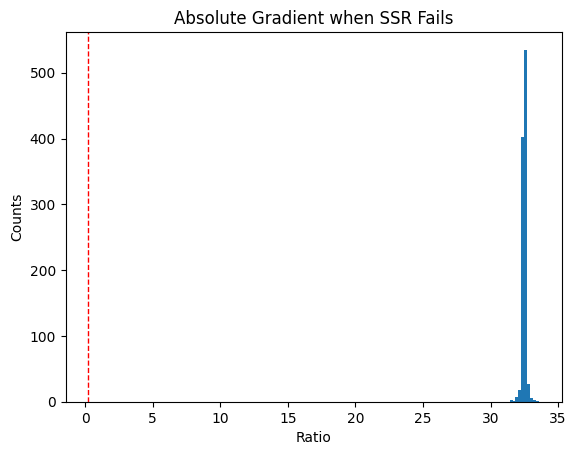

1000


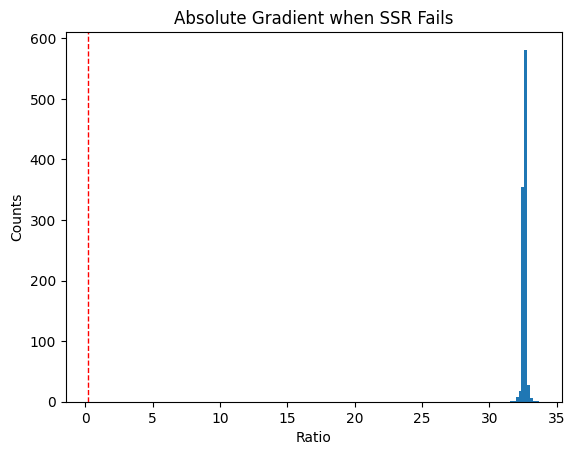

1000


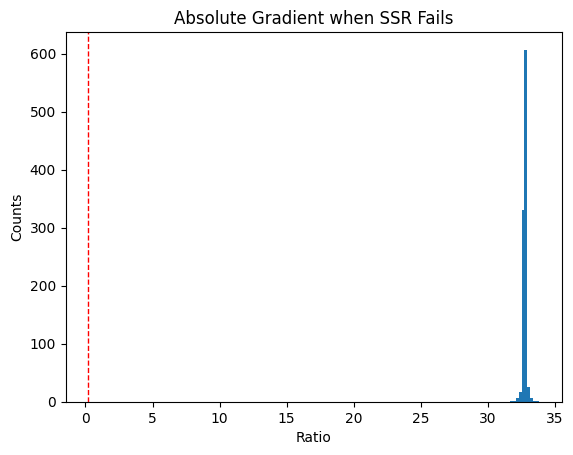

1000


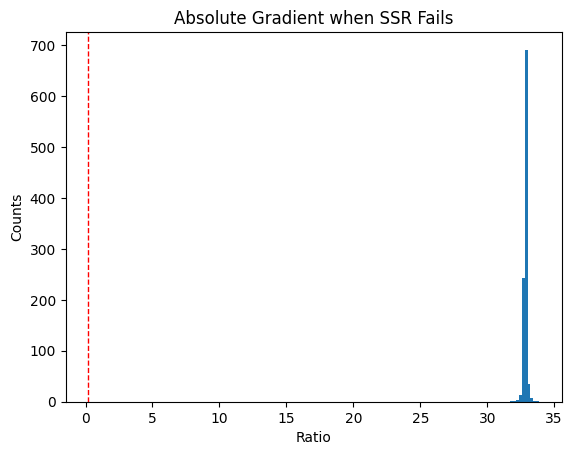

1000


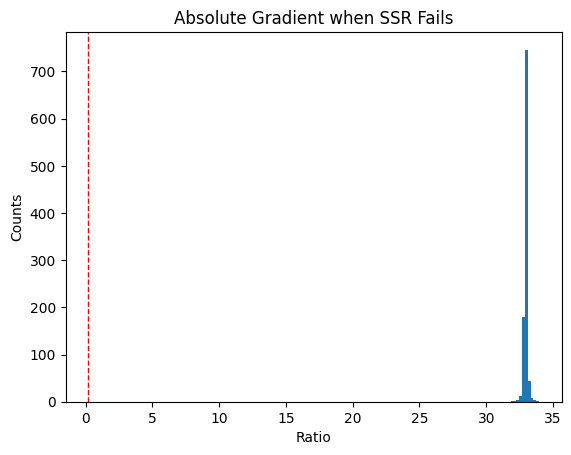

1000


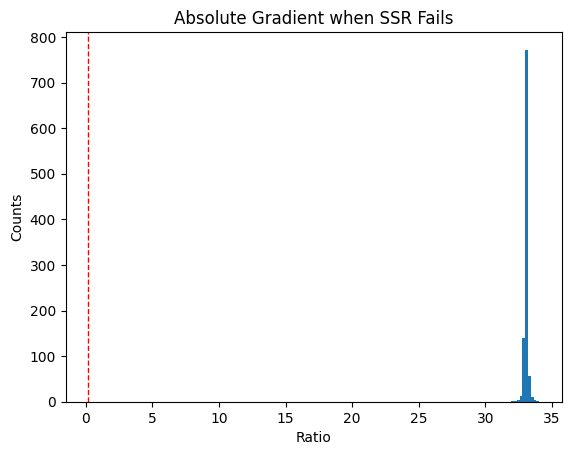

1000


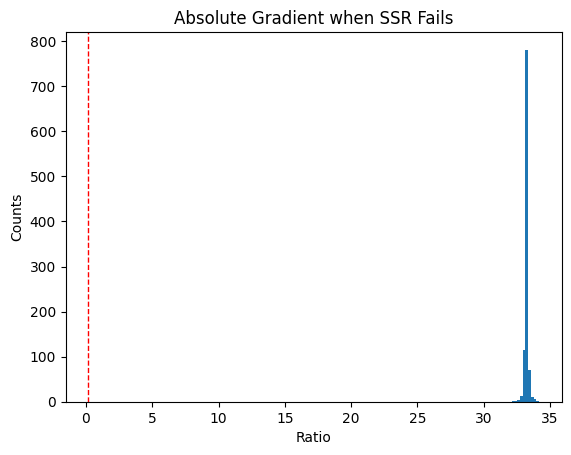

1000


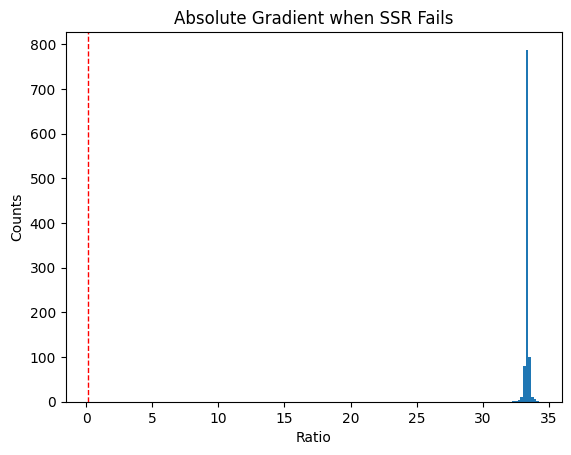

1000


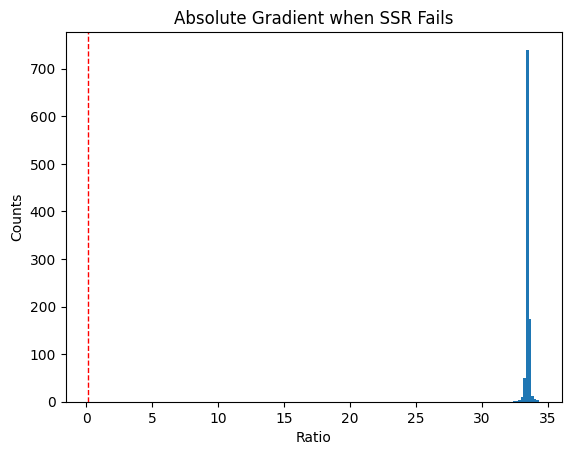

1000


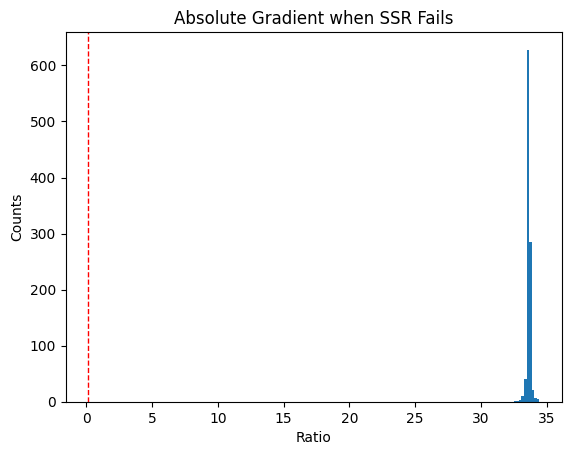

1000


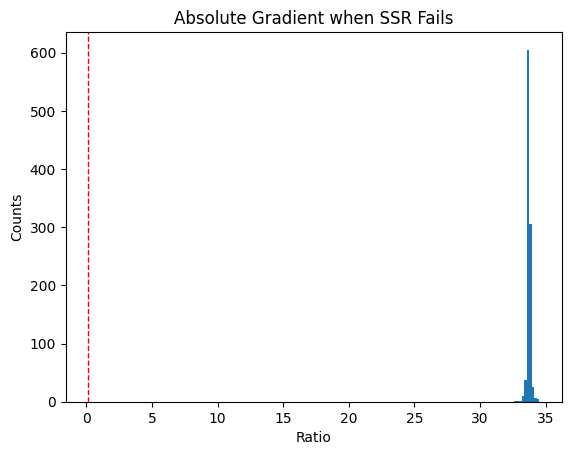

1000


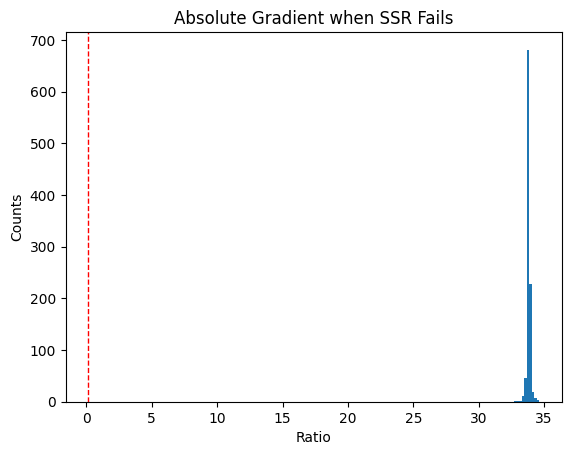

KeyboardInterrupt: 

In [11]:
def kkt_norm(X, y, groups, group_sizes, beta, lmda, alpha, penalty):
    rep_penalty = np.repeat(penalty, group_sizes)
    grad = X.T @ (y - X @ beta) - lmda * (1 - alpha) * rep_penalty * beta
    abs_grad = np.array([
        np.linalg.norm(grad[g : g + gs])
        for g, gs in zip(groups, group_sizes)
    ])
    return abs_grad

for i in range(out_naive['betas'].shape[-1]-1):
    b = out_naive['betas'][:, i]
    abs_grad = kkt_norm(X,y,groups,group_sizes,b,out_naive['lmdas'][i],alpha,penalty) / penalty
    thresh = (2 * out_naive['lmdas'][i+1] - out_naive['lmdas'][i]) * alpha 
    abs_grad = abs_grad[abs_grad > thresh]
    if len(abs_grad) == 0: continue
    print(len(abs_grad))
    plt.hist(abs_grad)
    plt.title("Absolute Gradient when SSR Fails")
    plt.axvline(thresh, color='red', linestyle='--', linewidth=1)
    plt.ylabel("Counts")
    plt.xlabel("Ratio")
    plt.show()

In [12]:
def run_cvxpy(X, y, groups, group_sizes, alpha, penalty, lmda):
    _, p = X.shape
    beta = cp.Variable(p)
    regul = 0
    for i in range(len(groups)):
        gb = groups[i]
        ge = gb + group_sizes[i]
        bi_norm2 = cp.norm2(beta[gb:ge])
        regul += penalty[i] * (alpha * bi_norm2 + (1-alpha) / 2 * cp.sum_squares(beta[gb:ge]))
    objective = cp.Minimize(0.5 * cp.sum_squares(y - X @ beta) + lmda * regul)
    prob = cp.Problem(objective)
    result = prob.solve()
    return beta.value 


In [13]:
lmdas = np.array(out_naive['lmdas'][:10])
cvxpy_betas = np.empty((p, len(lmdas)))
for i in tqdm(range(len(lmdas))):
    cvxpy_betas[:, i] = run_cvxpy(X, y, groups, group_sizes, alpha=1, penalty=np.sqrt(group_sizes), lmda=lmdas[i])

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jhyang/opt/miniconda3/envs/glstudy/lib/python3.10/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


In [ ]:
for j in range(cvxpy_betas.shape[0]):
    if j % (10) == 0:
        plt.plot(-np.log(out['lmdas']), cvxpy_betas[j])
plt.title('$\\beta$ Profile')
plt.xlabel('$-\log(\lambda)$')
plt.ylabel('$\\beta$')
plt.tight_layout()
plt.show()